In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [2]:
from scipy.stats import kendalltau, pearsonr, spearmanr
def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]
def spearmanr_pval(x,y):
    return spearmanr(x,y)[1]
# def sig_pv(x):
#     if x <= 0.05:
#         return 1
#     return 0

In [3]:
oral_tax = pd.read_csv('../data/metagenome/motus_profile.csv')
spnames = [ x.split('[ref')[0].split('[meta')[0].split('[ext')[0].\
           replace('[','').replace(']','').strip() for x in list(oral_tax['Species'])]
oral_tax['Species'] = spnames; oral_tax = oral_tax.rename(columns={'Species':'Sample'})
oral_tax = oral_tax.set_index(['Sample'])
oral_tax = oral_tax.T; oral_quant = oral_tax.groupby(oral_tax.columns, axis=1).sum();
oral_quant = oral_quant.drop(['unassigned'],axis=1)
oral_quant.head()

Sample,Abiotrophia defectiva,Acidaminococcus species incertae sedis,Acidovorax wautersii,Acinetobacter baumannii,Actinobacteria sp.,Actinobaculum sp. oral taxon 183,Actinomyces bouchesdurhonensis,Actinomyces dentalis,Actinomyces gerencseriae,Actinomyces graevenitzii,...,Veillonella atypica,Veillonella denticariosi,Veillonella dispar,Veillonella parvula,Veillonella rogosae,Veillonella sp.,Veillonella species incertae sedis,Veillonella tobetsuensis,Weissella confusa,Weissella paramesenteroides
A10,0.000198,0.0,0.0,0.000000,0.003645,0.000081,0.000000,0.000277,0.000086,0.005495,...,0.001063,0.0,0.002468,0.001105,0.041786,0.001101,0.003468,0.004988,0.0,0.0
A11,0.000440,0.0,0.0,0.000000,0.008368,0.000030,0.016645,0.000115,0.000046,0.016826,...,0.037476,0.0,0.015411,0.003669,0.000787,0.000278,0.039186,0.000157,0.0,0.0
A1,0.010644,0.0,0.0,0.000000,0.003527,0.000910,0.000000,0.000773,0.000822,0.001720,...,0.000949,0.0,0.001753,0.003181,0.011843,0.013361,0.006406,0.002494,0.0,0.0
A20,0.000000,0.0,0.0,0.000672,0.008431,0.001276,0.000000,0.001029,0.001319,0.004478,...,0.003533,0.0,0.004752,0.022527,0.007487,0.002804,0.016425,0.000000,0.0,0.0
A28,0.003256,0.0,0.0,0.000000,0.001518,0.000587,0.000000,0.000649,0.000553,0.000000,...,0.001448,0.0,0.000752,0.003571,0.018238,0.001710,0.003183,0.001323,0.0,0.0


In [4]:
oral_avg = pd.DataFrame( oral_quant.mean(axis=0), columns=['Average']).sort_values(['Average'],ascending=False)
top50_avg = oral_avg.iloc[:50]; rest_avg = oral_avg.iloc[50:];

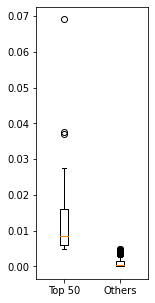

In [5]:
fig, ax = plt.subplots(1,1,figsize=(2,5))
ax.boxplot([top50_avg.Average,rest_avg.Average ], labels=['Top 50','Others']);

In [6]:
Top50_sps = list(top50_avg.index)
Top50sp_quant = oral_quant[Top50_sps]

In [7]:
genus_colors = {'Streptococcus':'tab:orange','Prevotella':'tab:red','Alloprevotella':'tab:red',
               'Haemophilus':'tab:blue','Neisseria':'tab:purple','Porphyromonas':'tab:olive','Veillonella':'tab:brown'}

# Species-species

In [8]:
sps_corr = Top50sp_quant.corr(method='spearman')
sps_sig = Top50sp_quant.corr( method= spearmanr_pval )
sig_sps_corr = sps_corr.copy()
for x in Top50_sps:
    for y in Top50_sps:
        if sps_sig[x][y] > 0.001:
            sig_sps_corr[x][y] = 0
sig_sps_corr = sig_sps_corr[(sig_sps_corr != 0).any(axis=1)]
sig_sps_corr = sig_sps_corr.loc[:, (sig_sps_corr != 0).any(axis=0)]

<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

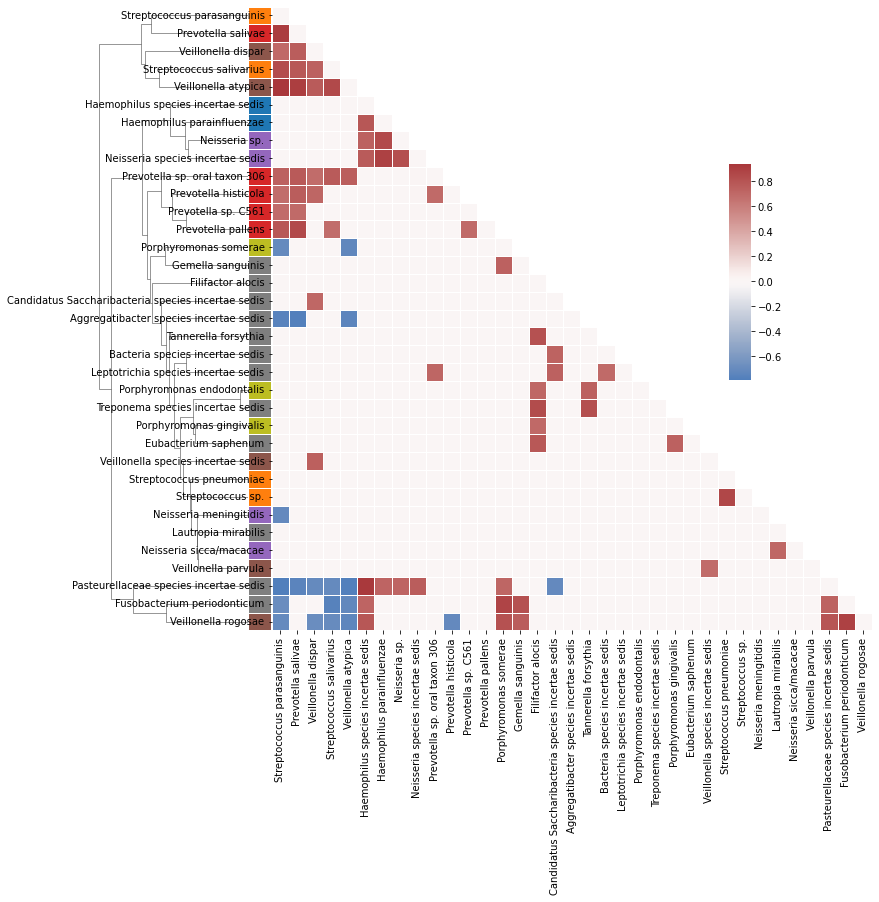

In [9]:
row_colors=[]
for sp in sig_sps_corr.columns:
    if sp.split(' ')[0] not in genus_colors:
        row_colors.append('tab:gray')
    else:
        row_colors.append( genus_colors[sp.split(' ')[0]] )
        
plt.figure()
mask = np.zeros_like(sig_sps_corr)
mask[np.triu_indices_from(mask)] = True
g = sns.clustermap(data=sig_sps_corr,mask = mask, cmap='vlag')
mask = mask[np.argsort(g.dendrogram_row.reordered_ind),:]
mask = mask[:,np.argsort(g.dendrogram_col.reordered_ind)]
mask[np.diag_indices_from(mask)] = False
plt.clf()
g1=sns.clustermap(sig_sps_corr,figsize=(15,15),cmap="vlag", row_colors=row_colors,
                  center=0,linecolor='white',linewidths=1,mask = mask)
g1.ax_col_dendrogram.remove();
g1.ax_heatmap.axes.yaxis.set_ticks_position('left')
g1.ax_cbar.set_position([0.6,0.5,0.02,0.2]);
g1.ax_heatmap.set_xlabel('');
g1.ax_heatmap.set_ylabel('');
# plt.savefig('../../../../Oral_paper/Figures_2025/heatmap_sp_corr.svg',format='svg',dpi=150)

In [26]:
G_sp = nx.Graph(name = 'Species_Corr')
vs = list(sig_sps_corr.columns)
G_sp.add_nodes_from([(v,{"color": 'tab:purple' }) for v in vs])
edge_list = []
for i in range(len(sig_sps_corr.columns)):
    for j in range(i):
        weight = sig_sps_corr.iloc[i,j]
        v1, v2 = list(sig_sps_corr.columns)[i], list(sig_sps_corr.columns)[j]
        if weight > 0:
            edge_list.append( (v1,v2,{'weight':abs(weight)*2,'edgecolor':'tab:red'}) )
        elif weight < 0:
            edge_list.append( (v1,v2,{'weight':abs(weight)*2,'edgecolor':'tab:blue'}) )
G_sp.add_edges_from(edge_list)

['Streptococcus salivarius', 'Neisseria sp.', 'Neisseria species incertae sedis', 'Bacteria species incertae sedis', 'Prevotella sp. oral taxon 306', 'Veillonella atypica', 'Veillonella species incertae sedis', 'Prevotella histicola', 'Leptotrichia species incertae sedis', 'Gemella sanguinis', 'Aggregatibacter species incertae sedis', 'Veillonella dispar', 'Veillonella parvula', 'Porphyromonas somerae', 'Neisseria meningitidis', 'Haemophilus parainfluenzae', 'Candidatus Saccharibacteria species incertae sedis', 'Prevotella sp. C561', 'Veillonella rogosae', 'Prevotella pallens', 'Pasteurellaceae species incertae sedis', 'Prevotella salivae', 'Haemophilus species incertae sedis', 'Fusobacterium periodonticum', 'Streptococcus parasanguinis']
['Porphyromonas endodontalis', 'Treponema species incertae sedis', 'Filifactor alocis', 'Tannerella forsythia', 'Porphyromonas gingivalis', 'Eubacterium saphenum']
['Streptococcus sp.', 'Streptococcus pneumoniae']
['Neisseria sicca/macacae', 'Lautropi

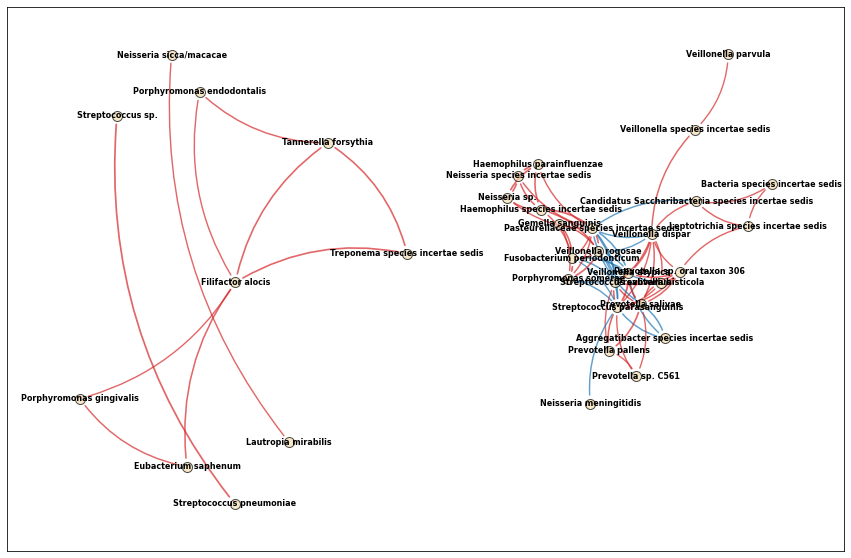

In [27]:
fig, ax = plt.subplots(1,1,figsize=(15,10))
nodecolors = [ 'wheat' for v in G_sp.nodes]
edgecolors = [G_sp[u][v]['edgecolor'] for u,v in G_sp.edges]
weights = [G_sp[u][v]['weight'] for u,v in G_sp.edges]
coms_sp = nx.community.greedy_modularity_communities(G_sp,best_n=4)
supergraph = nx.cycle_graph(len(coms_sp))
superpos = nx.spring_layout(G_sp, scale=2,seed=0)
centers = list(superpos.values())
pos = {}
for center, com in zip(centers, coms_sp):
    pos.update(nx.spring_layout(nx.subgraph(G_sp, com), center=center, seed=0))
for nodes in coms_sp:
    print(list(nodes))
    nx.draw_networkx_nodes(G_sp, pos=pos, nodelist=nodes, node_color='wheat',alpha=0.7,
                           edgecolors='black',node_size=100,ax=ax)
nx.draw_networkx_edges(G_sp, pos=pos,edge_color=edgecolors, width=weights, 
                       connectionstyle="arc3,rad=0.2",arrows=True,arrowstyle="-",alpha=0.7,ax=ax)
nx.draw_networkx_labels(G_sp, pos=pos,font_weight='bold',font_size=8 );
# plt.savefig('../../../../Oral_paper/Figures_2025/corrnetwork_sp.svg',format='svg',dpi=150)

In [28]:
for v in ['Porphyromonas endodontalis', 'Treponema species incertae sedis', 'Filifactor alocis', 
          'Tannerella forsythia', 'Porphyromonas gingivalis', 'Eubacterium saphenum',
          'Streptococcus sp.', 'Streptococcus pneumoniae','Neisseria sicca/macacae', 'Lautropia mirabilis']:
    G_sp.remove_node(v)

['Prevotella sp. C561', 'Prevotella pallens', 'Streptococcus salivarius', 'Prevotella sp. oral taxon 306', 'Veillonella atypica', 'Veillonella species incertae sedis', 'Prevotella histicola', 'Prevotella salivae', 'Aggregatibacter species incertae sedis', 'Veillonella dispar', 'Veillonella parvula', 'Neisseria meningitidis', 'Streptococcus parasanguinis']
['Veillonella rogosae', 'Neisseria sp.', 'Neisseria species incertae sedis', 'Porphyromonas somerae', 'Pasteurellaceae species incertae sedis', 'Haemophilus species incertae sedis', 'Gemella sanguinis', 'Fusobacterium periodonticum', 'Haemophilus parainfluenzae']
['Leptotrichia species incertae sedis', 'Bacteria species incertae sedis', 'Candidatus Saccharibacteria species incertae sedis']


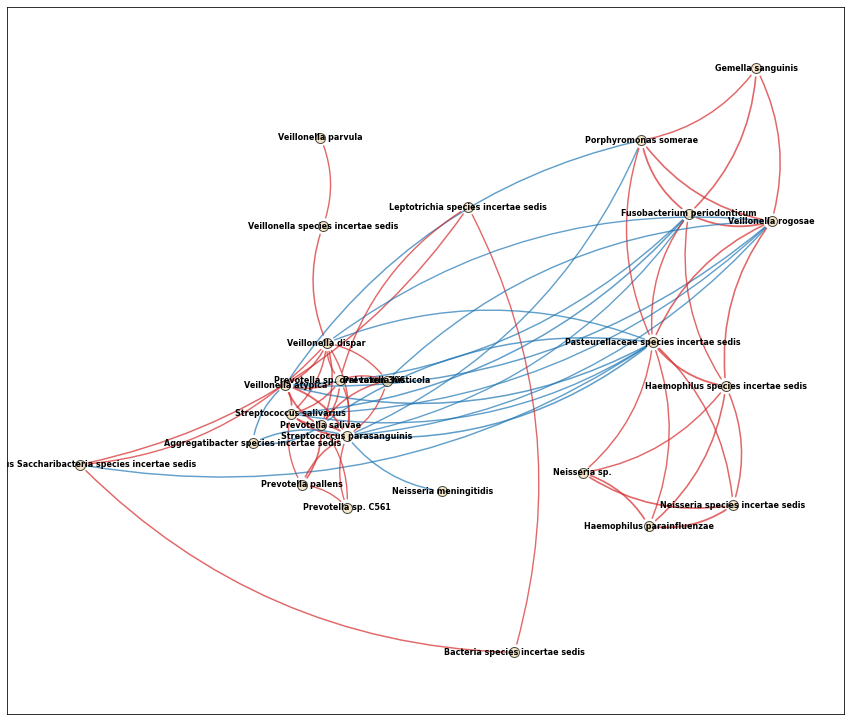

In [39]:
fig, ax = plt.subplots(1,1,figsize=(15,13))
nodecolors = [ 'wheat' for v in G_sp.nodes]
edgecolors = [G_sp[u][v]['edgecolor'] for u,v in G_sp.edges]
weights = [G_sp[u][v]['weight'] for u,v in G_sp.edges]
coms_sp = nx.community.greedy_modularity_communities(G_sp,best_n=3)
supergraph = nx.cycle_graph(len(coms_sp))
superpos = nx.spring_layout(G_sp, scale=2,seed=42)
centers = list(superpos.values())
pos = {}
for center, com in zip(centers, coms_sp):
    pos.update(nx.spring_layout(nx.subgraph(G_sp, com), center=center, seed=0))
for nodes in coms_sp:
    print(list(nodes))
    nx.draw_networkx_nodes(G_sp, pos=pos, nodelist=nodes, node_color='wheat',alpha=0.7,
                           edgecolors='black',node_size=100,ax=ax)
nx.draw_networkx_edges(G_sp, pos=pos,edge_color=edgecolors, width=weights, 
                       connectionstyle="arc3,rad=0.2",arrows=True,arrowstyle="-",alpha=0.7,ax=ax)
nx.draw_networkx_labels(G_sp, pos=pos,font_weight='bold',font_size=8 );
# plt.savefig('../../../../Oral_paper/Figures_2025/corrnetwork_sp.svg',format='svg',dpi=150)

# Species-metabolites

In [19]:
lcms = pd.read_csv('../data/metabolome/lcms_kegg.csv')
lcms = lcms.rename(columns={'Compound':'Sample'})
lcms = lcms.set_index(['Sample'])
lcms_avg = pd.DataFrame( lcms.mean(axis=1) ,columns=['Avg'])
lcms_avg = lcms_avg.sort_values(by=['Avg'],ascending=False)
Top100_lcms = lcms.loc[list( lcms_avg.index)[:100]]
Top100_lcms = Top100_lcms.T
Top100_lcms = Top100_lcms.reindex(list(Top50sp_quant.index)).div(100)
met_sp = pd.merge(Top100_lcms, Top50sp_quant, left_index=True, right_index=True)

In [21]:
met_sp_corr = met_sp.corr(method='spearman')
met_sp_corr = met_sp_corr.drop(list(Top100_lcms.columns),axis=0).drop(list(Top50sp_quant.columns),axis=1)
met_sp_pval = met_sp.corr( method= spearmanr_pval )
met_sp_pval = met_sp_pval.drop(list(Top100_lcms.columns),axis=0).drop(list(Top50sp_quant.columns),axis=1)

In [33]:
sig_metsp_corr = met_sp_corr.copy()
for x in list(Top100_lcms.columns):
    for y in list(Top50sp_quant.columns):
        if met_sp_pval[x][y] > 0.01:
            sig_metsp_corr[x][y] = 0
sig_metsp_corr = sig_metsp_corr.drop(['N-Acetyl-a-neuraminic acid'],axis=1)
sig_metsp_corr = sig_metsp_corr[(sig_metsp_corr != 0).any(axis=1)]
sig_metsp_corr = sig_metsp_corr.loc[:, (sig_metsp_corr != 0).any(axis=0)]

<Figure size 432x288 with 0 Axes>

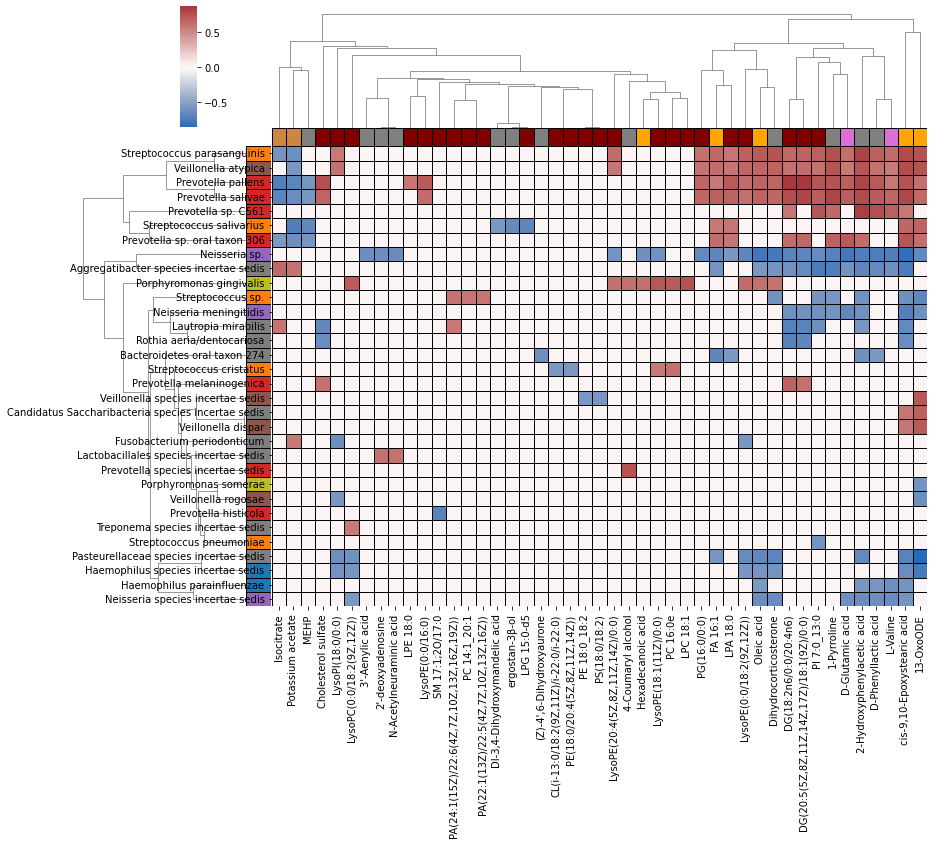

In [41]:
row_colors=[]; col_colors=[];
for sp in sig_metsp_corr.index:
    if sp.split(' ')[0] not in genus_colors:
        row_colors.append('tab:gray')
    else:
        row_colors.append( genus_colors[sp.split(' ')[0]] )
for met in sig_metsp_corr.columns:
    if (':' in met and met != 'FA 16:1') or met == 'Cholesterol sulfate':
        col_colors.append('maroon')
    elif met in ['Oleic acid','Hexadecanoic acid','cis-9,10-Epoxystearic acid','FA 16:1','13-OxoODE']:
        col_colors.append('orange')
    elif met in ['L-Valine','D-Glutamic acid']:
        col_colors.append('orchid')
    elif met in ['Isocitrate', 'Potassium acetate']:
        col_colors.append('peru')
    else:
        col_colors.append('tab:gray')
        
plt.clf()
g=sns.clustermap(data=sig_metsp_corr, figsize=(16,12), linecolor='black',linewidths=1, 
                 row_colors=row_colors,col_colors=col_colors, cmap='vlag',center=0)
g.ax_heatmap.set_xlabel('')
g.ax_heatmap.set_ylabel('')
g.ax_cbar.set_position([0.1,0.85,0.015,0.14])
g.ax_heatmap.axes.yaxis.set_ticks_position('left')
# plt.savefig('../../../../Oral_paper/Figures_2025/heatmap_spmet_corr.svg',format='svg',dpi=150)

In [48]:
# G_ms =  nx.Graph(name = 'met_sp_corr')
# vs = list(sig_metsp_corr.columns)+list(sig_metsp_corr.index)
# G_ms.add_nodes_from([(v,{"color": 'tab:purple' }) for v in vs])
# edge_list = []
# for i in range(len(sig_metsp_corr.columns)):
#     for j in range(len(sig_metsp_corr.index)):
#         weight = sig_metsp_corr.iloc[j,i]
#         v1, v2 = list(sig_metsp_corr.columns)[i], list(sig_metsp_corr.index)[j]
#         if weight > 0:
#             edge_list.append( (v1,v2,{'weight':abs(weight)*2,'edgecolor':'tab:red'}) )
#         elif weight < 0:
#             edge_list.append( (v1,v2,{'weight':abs(weight)*2,'edgecolor':'tab:blue'}) )
# G_ms.add_edges_from(edge_list)

In [30]:
# fig, ax = plt.subplots(1,1,figsize=(14,10))
# def get_vcolor(v):
#     if v in list(sig_metsp_corr.columns):
#         c = 'plum'
#     else:
#         c='wheat'
#     return c
# edgecolors = [G_ms[u][v]['edgecolor'] for u,v in G_ms.edges]
# weights = [G_ms[u][v]['weight'] for u,v in G_ms.edges]
# coms_ms = nx.community.greedy_modularity_communities(G_ms)
# supergraph = nx.cycle_graph(len(coms_ms))
# superpos = nx.spring_layout(G_ms, scale=10, seed=0)
# centers = list(superpos.values())
# pos = {}
# for center, com in zip(centers, coms_ms):
#     pos.update(nx.spring_layout(nx.subgraph(G_ms, com), center=center, seed=42))
# for nodes in coms_ms:
#     print(list(nodes))
#     colors = [get_vcolor(v) for v in list(nodes)]
#     nx.draw_networkx_nodes(G_ms, pos=pos, nodelist=nodes, node_size=100, node_color=colors,alpha=0.7,edgecolors='black',ax=ax)
# nx.draw_networkx_edges(G_ms, pos=pos,edge_color=edgecolors, width=weights, alpha=0.7,ax=ax)
# nx.draw_networkx_labels(G_ms, pos=pos,font_weight='bold',font_size=8 );